# Performing NCGR at a gridpoint
This notebook walks you through how to use the `NCGR` package to perform non-homogenous Gaussian regression (NCGR) on an ice-free date or freeze-up date ensemble forecast at a single location using the `NCGR.ncgr_gridpoint` module. This option is perhaps preferred if you don't want to rely on the requirements involved in the `ncgr_fullfield()` module, if memory limitations prevent you from using `ncgr_fullfield()`, or if you would like to modify or have more control over different steps of the NCGR algorithm.  

Outline
-----------
* The first section of this noetbook, **Main Recipe**, provides the relevant function calls to perform NCGR and produce relevant forecast variables.

* The second section of this notebook, **Working Script**, offers a copy and pasteable section of code that loads some sample hindcasts and observations at a single gridpoint and performs NCGR on a forecast for a specified year.

* The third section of the notebook, **Detailed explanation & plotting**, goes through step-by-step and provides insights on each piece of code, the data, and creates plots showing the results. 

*Hint: You can hold "shift+tab" inside the parenthesis of any function in the notebook to see its help/docstring.*


Main Recipe
------------------
```python 
from NCGR import ncgr

# instatiate the ncgr_gridpoint and fcst_vs_clim modules
ngp = ncgr.ncgr_gridpoint(a, b)
fvc = ncgr.fcst_vs_clim(a,b) 

# build model
predictors_tau, predictors_t, coeffs0 = ngp.build_model(X_t, X_tau, Y_tau, tau, t)

# optimize/minimize the CRPS to estimate regression coefficients
coeffs = ngp.optimizer(Y_tau, predictors_tau, coeffs0)

# Compute calibrated forecast distribution parameters for year t
mu_t, sigma_t = ngp.forecast_mode(predictors_t, coeffs)

# get relevant forecast information based on the forecast distribution
result = fvc.event_probs(mu_t, sigma_t, Y_clim)
fcst_probs, clim_terc, clim_params = result.probs, result.terciles, result.params
```

## Bare-bones code

In [1]:
from NCGR import ncgr, sitdates
import numpy as np

# load data
X_all = np.load('Data/fud_X.npy') 
Y_all = np.load('Data/fud_Y.npy') 

# define time variables
event='fud' 
years_all = np.arange(1979, 2017+1)
im = 12 # initialization month

# instantiate the sitdates class
si_time = sitdates.sitdates(event=event)
a = si_time.get_min(im) # minimum date possible
b = si_time.get_max(im) # maximum date possible


# instatiate the ncgr_gridpoint module
ngp = ncgr.ncgr_gridpoint(a, b)
# instantiate the fcst_vs_clim module
fvc = ncgr.fcst_vs_clim(a,b) 


# the forecast year to calibrate
t=2016 

# set up relevant time variables for calibrating the forecast
# using data only from previous
t_idx = np.where(years_all==t)[0][0]
tau = years_all[years_all<t] # years used for training
X_tau = X_all[years_all<t,:] # training hindcasts
Y_tau = Y_all[years_all<t] # training observations
X_t = X_all[t_idx] # forecast to be calibrated
Y_t = Y_all[t_idx] # the observed freeze-up date corresponding to the forecast

############## calibration  #######################
# build calibration model
predictors_tau, predictors_t, coeffs0 = ngp.build_model(X_t, X_tau, Y_tau, tau, t)

# optimize/minmize the CRPS to estimate regression coefficients
coeffs = ngp.optimizer(Y_tau, predictors_tau, coeffs0)

# Compute calibrated forecast distribution parameters for year t
mu_t, sigma_t = ngp.forecast_mode(predictors_t, coeffs)
print("Calibrated forecast distribution parameters (mu,sigma):", [mu_t, sigma_t])

###### Compute forecast probabilities relative to climatology #################
n_clim=10 # number of years preceding the forecast to use as climatology (note: this is not the training period)
Y_clim = Y_all[t_idx-n_clim:t_idx] # observations for defining the climatology (past 10 years for this example) 

# get result
result = fvc.event_probs(mu_t, sigma_t, Y_clim)

# unpack result
fcst_probs, clim_terc, clim_params = result.probs, result.terciles, result.params

print("Probilities for early, normal, late freeze-up:", fcst_probs)
print("Climatology terciles:", clim_terc)
print("Climatology distribution parameters (mu,sigma):", clim_params)

Calibrated forecast distribution parameters (mu,sigma): [360.06167043316805, 15.537755970468954]
Probilities for early, normal, late freeze-up: [0.08214745 0.24499739 0.67285516]
Climatology terciles: [338.45221123 353.10369408]
Climatology distribution parameters (mu,sigma): [345.77795265  17.00784101]


## Detailed explanation & plotting the result

First import the relevant libraries:

In [2]:
# same as above
from NCGR import ncgr, sitdates
from NCGR.dcnorm import dcnorm_gen
import numpy as np

# plus a few extras for analysing data and plotting
#from NCGR.dcnorm import dcnorm_gen
from dcnorm import dcnorm_gen 
from scipy.stats import pearsonr
from scipy.signal import detrend
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import datetime

Load pre-saved arrays containing hindcasts and observations at a single gridpoint:

In [3]:
X_all = np.load('Data/fud_X.npy') 
Y_all = np.load('Data/fud_Y.npy') 

years_all = np.arange(1979, 2017+1)

The array `X_all` contains 39 years of *freeze-up date* hindcasts (first dimension) and 10 ensemble members (second dimension) at a single gridpoint in the Bering Sea. These hindcasts were initialized on December 1, 1979-2017 (hence the new array introduced `years_all` which contains those same years). The array `Y` contains the corresponding observed freeze-up dates for the same location.

To get a sense of the data, we'll plot the time series of the hindcasts and observations, as well as a scatterplot comparing them:

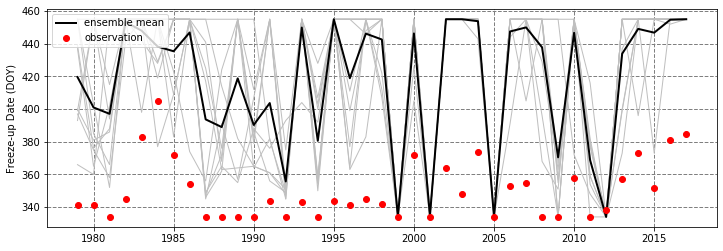

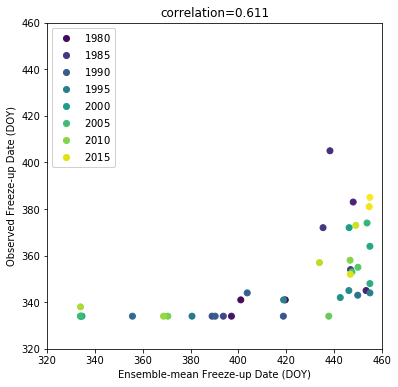

In [4]:
fig = plt.figure(num=1, figsize=(12,4))
ax1 = fig.add_subplot(111)
ax1.plot(years_all, X_all, '0.75', linewidth=1) # all ensemble members
ax1.plot(years_all, X_all.mean(axis=1), 'k-', linewidth=2, label='ensemble mean') 
ax1.plot(years_all, Y_all, 'ro', label='observation')
ax1.grid(linestyle='--',color='0.5',linewidth=1.0)
ax1.legend(loc='upper left')
ax1.set_ylabel('Freeze-up Date (DOY)')

fig = plt.figure(num=2, figsize=(6,6))
ax2 = fig.add_subplot(111)
scatter = ax2.scatter(X_all.mean(axis=1), Y_all, c=years_all, cmap='viridis')
ax2.set_title("correlation=%s" %str(np.around(pearsonr(X_all.mean(axis=1), Y_all)[0],3)))
legend = ax2.legend(*scatter.legend_elements(),
                    loc="upper left", ncol=1)
ax2.set_xlim((320,460))
ax2.set_ylim((320,460))
ax2.set_xlabel('Ensemble-mean Freeze-up Date (DOY)')
ax2.set_ylabel('Observed Freeze-up Date (DOY)')
ax2.add_artist(legend)
plt.show()

The hindcast freeze-up date typically occurs much later than the observed freeze-up date; However, there is a relatively strong correlation between the ensemble mean and the observation (0.61). 

We'll now create some time-like variables required for calibration:

In [5]:
im=12 # define the initialization month (December)

# instantiate the sitdates class and provide the event of interest
si_time = sitdates.sitdates(event='fud')
a = si_time.get_min(im) # minimum date possible
b = si_time.get_max(im) # maximum date possible
print("a=%d, b=%d"%(a,b))

a=334, b=455


In the above section of code, we've made use of the `sidates` module by instantiating it with the event variable (in this case 'fud' for *freeze-up date*; for the retreat season we would set event='ifd'). By doing so, and by calling on `si_time.get_min()` and `si_time.get_max()` with the initialization month as an input argument, the minimum and maximum dates possible are returned. These are printed as `a=334` and `b=455`. Reading the docstring for `sidates.sitdates()` you'll see that default dates are set to those given in [1].

### *Useful side-note*:
If rather different conventions are used for your data, you can change the dates associated with `si_time.get_min()` and `si_time.get_max()` using `si_time.set_min()` and `si_time.set_max()`. For example, for `im=12`, the convention in [1] is to consider the freeze-up date for the current freeze season. If rather your hindcast and observed data were created so that the freeze-up date is for the following season, you could change the minimum and maximum dates corresponding to `im=12` accordingly with:

```python
si_time.set_min(im, 538) # corresponding to the start of the freeze season (October 1) for the next year
si_time.set_max(im, 699) # November 30 of the following year (if e.g. the forecast was run for 12 months)
```
Those dates are then set and the minimum and maximum dates can be retrieved at any time within the working script using:

```python
a = si_time.get_min(im)
b = si_time.get_max(im)
```

We'll now define the year of the forecast to be calibrate and split the data in ``X_all`` and ``Y_all`` into the training and testing data. For this example, we'll emulate an operational scenario and only use data from years preceding the year being calibrated to train the calibration model.

In [6]:
t = 2016 # the forecast initialization year
tau = years_all[years_all<t] # years used for training
X_tau = X_all[years_all<t,:] # training hindcasts
Y_tau = Y_all[years_all<t] # training observations
X_t = X_all[years_all==t] # forecast to be calibrated
Y_t = Y_all[years_all==t] # the observed freeze-up date corresponding to the forecast

The calibration is carried out in two function calls. First, we must create an instance of the `ncgr.ncgr_gridpoint` module, providing it with the minimum and maximum dates possible. We'll call it ``ngp``:

In [7]:
ngp = ncgr.ncgr_gridpoint(a, b)

Now we can use this ``ngp`` object to build the predictors and initial-coefficient guesses to be used to estimate the regression coefficients:

In [8]:
# build calibration model
predictors_tau, predictors_t, coeffs0 = ngp.build_model(X_t, X_tau, Y_tau, tau, t)

The predictors are given in two variables: ``predictors_tau``, which correspond to the predictors over the training period, and ``predictors_t``, which are the predictors for the forecast year of interest. ``coeffs0`` is a 4x1 array containing the initial guesses for the coefficients to be estimated.

Now we'll estimate the regression coefficients for the calibration model by calling on `ngp.optimizer`, which minimizes the continuous rank probability score (CRPS) over the training data:

In [9]:
# optimize/minmize the CRPS to estimate regression coefficients
coeffs = ngp.optimizer(Y_tau, predictors_tau, coeffs0)

Now that we have the optimized coefficients, we can estimate the distribution parameters in forecast mode, $\mu$ and $\sigma$, using `ngp.forecast_mode`:

In [10]:
# Compute calibrated forecast distribution parameters for year t
mu_t, sigma_t = ngp.forecast_mode(predictors_t, coeffs)

At this point, it's worth mentioning that if you would like to know how to use these parameters to compute various statistics from a DCNORM distribution, take a look at the `DCNORM_distribution_example.ipnyb` notebook provided in this folder. We'll take a look at the forecast distribution in a moment with a couple examples, but first let's compute the forecast probabilities for early, normal, and late sea-ice advance given our distribution parameters. To do this, we'll need to use another NCGR module called `fcst_vs_clim`:

In [11]:
# instantiate the fcst_vs_clim module
fvc = ncgr.fcst_vs_clim(a,b) 

We need a reference to define our three categories, so we'll use the last observed advance dates for the last 10 years. These can be extracted from ``Y`` as follows:

In [12]:
n_clim=10 # number of years preceding the forecast to use as climatology (note: this is not the training period)
t_idx = np.where(years_all==t)[0][0] # the index of years_all, and thus Y_all, corresponding to the forecast year
Y_clim = Y_all[t_idx-n_clim:t_idx] # observations for defining the climatology

Now we have everything need to compute our forecast probabilities. By default the sample of climatological dates is fit to the DCNORM distribution to estimate the climatological terciles.

In [13]:
result = fvc.event_probs(mu_t, sigma_t, Y_clim)
# unpack result (forecast probabilities, climatological terciles, and climatological distribution parameters)
fcst_probs, clim_terc, clim_params = result.probs, result.terciles, result.params

Finally, we'll plot the calibrated forecast distribution and get a sense of how the forecast performed. For this, we'll rely on the `dcnorm` module imported earlier:

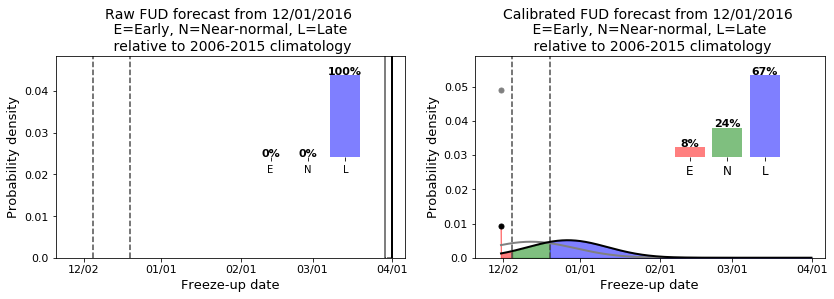

Observed date: 01/17
Observed category: Later than normal


In [14]:
#########################################################
######################## PLOTTING #######################
#########################################################
dcnorm = dcnorm_gen(a=a, b=b) # instantiate instance of dcnorm_gen (the DCNORM distribution module) with given a and b 
x = np.linspace(a,b,1000) # discretize the support
rv = dcnorm(mu_t, sigma_t) # freeze DCNORM distribution object with calibrated distribution parameters
rv_c = dcnorm(clim_params[0], clim_params[1]) #  # freeze DCNORM distribution object with the climatology distribution parameters

event='fud'

# A way to convert day-of-year dates to regular mm/dd for x-tick labelling in the plot
xticks = []
xticklabels = []
count = a 
while count<b+1:
    if count==a:
        # on first iteration, set to the initialization date
        date_curr = datetime.date(t,im,1) # create date object
        init_doy = si_time.date_to_doy(date_curr) # convert object to DOY
        xticks.append(init_doy) 
        xticklabels.append(si_time.doy_to_date(init_doy)) # convert DOY to mm/dd
    else:
        # otherwise convert to mm/dd if count is a DOY corresponding to the 1st of the month
        ddmm = si_time.doy_to_date(count)
        if ddmm[-2:]=='01':
            xticks.append(count)
            xticklabels.append(ddmm)
            
    count+=1


fig = plt.figure(figsize=(12,4))
######################## First plot the probability distribution for the raw forecast ################
ax = fig.add_subplot(121)
n, bins, patches = ax.hist(X_t,density=True, edgecolor='k', 
        linewidth=2,bins=20)

# plot climatological terciles as dashed lines
ax.vlines(clim_terc[0],0.0,max(rv.pdf(x).max()+0.05,rv_c.pdf(x).max()+0.05),
          colors='0.3', linestyles='--', linewidths=1.5)
ax.vlines(clim_terc[1],0.0,max(rv.pdf(x).max()+0.05,rv_c.pdf(x).max()+0.05),
          colors='0.3', linestyles='--', linewidths=1.5)

idx = 0
for c, p in zip(bins, patches):
    if c<=clim_terc[0]:
        plt.setp(p, 'facecolor', 'r',alpha=0.5)
    elif c>=clim_terc[1]:
        plt.setp(p, 'facecolor', 'b',alpha=0.5)
    else:
        plt.setp(p, 'facecolor', 'g',alpha=0.5)
        
    idx+=1
  
# insert axes for bars showing probabilities
ax2 = inset_axes(ax,
                  height="45%", # set height
                  width="45%", # and width
                  bbox_to_anchor=(0.0,0.0,0.95,0.95),
                  axes_kwargs={'frame_on':False},
                  bbox_transform=ax.transAxes)
center=0.5
offset=1.0

# compute forecast probabilities for the raw ensemble
p_en_raw = dcnorm.ecdf(clim_terc[0],X_t)[0]
p_nn_raw = dcnorm.ecdf(clim_terc[1],X_t)[0] - p_en_raw
p_ln_raw = 1 - dcnorm.ecdf(clim_terc[1],X_t)[0]

# creates a bar for each forecast probability in the inset axes
rect1 = plt.bar(center-offset/2,p_en_raw ,0.4, fc='r',alpha=0.5)
rect2 = plt.bar(center,p_nn_raw, 0.4, fc='g',alpha=0.5)
rect3 = plt.bar(center+offset/2,p_ln_raw, 0.4, fc='b',alpha=0.5)

plt.xlim(-0.5, 1.5)
plt.xticks([center-offset/2,center,center+offset/2])
plt.yticks([])
ax2.set_xticklabels(np.array(['E','N','L']))

ax2.text(center-offset/2, p_en_raw+0.01,str(int(round(p_en_raw*100,0)))+'%', 
       fontsize=11, ha='center',fontweight='semibold')
ax2.text(center, p_nn_raw+0.01,str(int(round(p_nn_raw*100,0)))+'%', 
       fontsize=11, ha='center',fontweight='semibold')
ax2.text(center+offset/2, p_ln_raw+0.01,str(int(round(p_ln_raw*100,0)))+'%', 
       fontsize=11, ha='center',fontweight='semibold')

ax.set_xlim((a-10.,b+5))
ax.set_ylim((0.0,rv.pdf(x).max()+0.05))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=11)
ax.set_yticklabels(np.arange(0.0,rv.pdf(x).max()+0.05,0.01),fontsize=11)
ax.set_ylabel('Probability density', fontsize=13)
ax.set_xlabel('Freeze-up date', fontsize=13)

ax.set_title('Raw '+event.upper()+' forecast from '+"%02d" % im+'/01/'+str(int(t))+
             ' \n E=Early, N=Near-normal, L=Late \n relative to '+str(t-n_clim)+'-'+str(t-1)+
             ' climatology', fontsize=14)



######### Now plot the probability distribution for the calibrated for the calibrated forecast #######
ax = fig.add_subplot(122)
# plot the climatological distribution first
ax.plot(x[1:-1], rv_c.pdf(x[1:-1]), color='0.5', linewidth=2)
# now plot end-dates if probability exists for pre/non occurence of the event
if rv_c.pdf(x[0])>1e-4:
    ax.plot(x[0], rv_c.pdf(x[0]), 'o', color='0.5', ms=5)
if rv_c.pdf(x[-1])>1e-4:
    ax.plot(x[-1], rv_c.pdf(x[-1]), 'o', color='0.5', ms=5)

# plot main forecast pdf curve (but exclude end-dates)
ax.plot(x[1:-1], rv.pdf(x[1:-1]), 'k',linewidth=2)
# now plot end-dates if probability exists for pre/non occurence of the event
if rv.pdf(x[0])>1e-4:
    ax.plot(x[0], rv.pdf(x[0]), 'ko', ms=5)
if rv.pdf(x[-1])>1e-4:
    ax.plot(x[-1], rv.pdf(x[-1]), 'ko', ms=5)

# fill colors under the forecast pdf according to each category
ax.fill_between(x[x<clim_terc[0]], 0.0, rv.pdf(x[x<clim_terc[0]]), color='r', alpha=0.5)

ax.fill_between(x[(x>clim_terc[0])&(x<clim_terc[1])], 0.0, 
                  rv.pdf(x[(x>clim_terc[0])&(x<clim_terc[1])]), color='g', alpha=0.5)

ax.fill_between(x[x>clim_terc[1]], 0.0, rv.pdf(x[x>clim_terc[1]]),color='b',alpha=0.5)

# plot climatological terciles as dashed lines
ax.vlines(clim_terc[0],0.0,max(rv.pdf(x).max()+0.05,rv_c.pdf(x).max()+0.05),
          colors='0.3', linestyles='--', linewidths=1.5)
ax.vlines(clim_terc[1],0.0,max(rv.pdf(x).max()+0.05,rv_c.pdf(x).max()+0.05),
          colors='0.3', linestyles='--', linewidths=1.5)

# insert axis for bars showing probabilities
ax2 = inset_axes(ax,
                  height="45%", # set height
                  width="45%", # and width
                  bbox_to_anchor=(0.0,0.0,0.95,0.95),
                  axes_kwargs={'frame_on':False},
                  bbox_transform=ax.transAxes)

center=0.5
offset=1.0

# plot bars showing probabilities
p_en_ncgr, p_nn_ncgr, p_ln_ncgr = fcst_probs

rect1 = plt.bar(center-offset/2, p_en_ncgr, 0.4, fc='r',alpha=0.5)
rect2 = plt.bar(center, p_nn_ncgr, 0.4, fc='g',alpha=0.5)
rect3 = plt.bar(center+offset/2, fcst_probs[2], 0.4, fc='b',alpha=0.5)


plt.xlim(-0.5, 1.5)
plt.xticks([center-offset/2,center,center+offset/2])
plt.yticks([])
ax2.set_xticklabels(np.array(['E','N','L']), fontsize=12)

ax2.text(center-offset/2, p_en_ncgr+0.01,str(int(round(p_en_ncgr*100,0)))+'%', 
         fontsize=11, ha='center',fontweight='semibold')
ax2.text(center, p_nn_ncgr+0.01,str(int(round(p_nn_ncgr*100,0)))+'%', 
         fontsize=11, ha='center',fontweight='semibold')
ax2.text(center+offset/2, p_ln_ncgr+0.01,str(int(round(p_ln_ncgr*100,0)))+'%', 
         fontsize=11, ha='center',fontweight='semibold')

ax.set_xlim((a-10.,b+5))
ax.set_ylim((0.0,max(rv.pdf(x).max()+0.05,rv_c.pdf(x).max()+0.05)))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=11)
ax.set_yticklabels(np.arange(0.0,rv.pdf(x).max()+0.05,0.01),fontsize=11)
ax.set_ylabel('Probability density', fontsize=13)
ax.set_xlabel('Freeze-up date', fontsize=13)

ax.set_title('Calibrated '+event.upper()+' forecast from '+"%02d" % im+'/01/'+str(int(t))+
             ' \n E=Early, N=Near-normal, L=Late \n relative to '+str(t-n_clim)+'-'+str(t-1)+
             ' climatology', fontsize=14)

fig.subplots_adjust(top=0.8, bottom=0.1, left=0.1, right=0.99, wspace=0.2)

plt.show()

print("Observed date:", si_time.doy_to_date(int(Y_t)))
if Y_t<=clim_terc[0]:
    p_en_obs = 1.0
    p_nn_obs = 0.0
    p_ln_obs = 0.0
    print("Observed category: Earlier than normal")
elif (Y_t>clim_terc[0])&(Y_t<=clim_terc[1]):
    p_en_obs = 0.0
    p_nn_obs = 1.0
    p_ln_obs = 0.0    
    print("Observed category: Near normal")
else:
    p_en_obs = 0.0
    p_nn_obs = 0.0
    p_ln_obs = 1.0
    print("Observed category: Later than normal")
    

To compute the CRPS for the raw forecast, we'll use the ``dcnorm.ecdf()`` function, and for the calibrated forecast we'll use the ``dcnorm.cdf()`` function:

In [15]:
crps_raw = np.trapz((dcnorm.ecdf(x,X_t) - dcnorm.ecdf(x,Y_t))**2.,x) 
crps_ncgr = np.trapz((rv.cdf(x) - dcnorm.ecdf(x,Y_t))**2.,x)
print("CRPS (raw) =",crps_raw)
print("CRPS (NCGR, approximate) =",crps_ncgr)

CRPS (raw) = 75.88238238238236
CRPS (NCGR, approximate) = 13.487902217819506


Note that we can also compute the CRPS for the calibrated forecast using the analytic expression for the CRPS with the NCGR library using the following:

In [16]:
crps_funcs = ncgr.crps_funcs(a,b) # instantiate instance of ``ncgr.crps_funcs``
crps_ncgr_true = crps_funcs.crps_dcnorm_single(Y_t, mu_t, sigma_t) # ``crps_dcnorm_single`` is used to compute CRPS for a single forecast
print("CRPS (NCGR, analytic) =",crps_ncgr_true)

CRPS (NCGR, analytic) = 13.442205531634983
